In [1]:
import pandas as pd

## Preprocessing data

In [4]:
df = pd.read_csv("sms-data/spam.csv", encoding="ISO-8859-1")

In [19]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [21]:
df.loc[5570].message

"The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free"

In [75]:
def nan_to_str(some_str):
    new_str = str(some_str)
    if new_str == "nan":
        return ""
    else:
        return new_str

In [78]:
messages = []
for i in df.iterrows():
    cur_mes = i[1]["v2"] + nan_to_str(i[1]["Unnamed: 2"]) + nan_to_str(i[1]["Unnamed: 3"]) + nan_to_str(i[1]["Unnamed: 4"])
    messages.append(cur_mes)

df["message"] = messages

In [83]:
processed_df = df
processed_df["class"] = df["v1"]
processed_df["is_spam"] = [1 if i == "spam" else 0 for i in df["class"]]

processed_df["message"] = df["message"]

processed_df = processed_df.drop(["v1", "v2", "Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [84]:
processed_df

,class,is_spam,message
0,ham,0,"Go until jurong point, crazy.. Available only ..."
1,ham,0,Ok lar... Joking wif u oni...
2,spam,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,0,U dun say so early hor... U c already then say...
4,ham,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...,...
5567,spam,1,This is the 2nd time we have tried 2 contact u...
5568,ham,0,Will Ì_ b going to esplanade fr home?
5569,ham,0,"Pity, * was in mood for that. So...any other s..."
5570,ham,0,The guy did some bitching but I acted like i'd...


In [85]:
processed_df.to_csv("sms-data/processed_data.csv", index=False)

In [3]:
df = pd.read_csv("sms-data/processed_data.csv", encoding="ISO-8859-1")

## Preparing data for BERT

In [9]:
!pip install wordcloud

     ------------------------------------ 153.1/153.1 KB 295.1 kB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'C:\Users\Иван\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [5]:
df["v1"] = df["class"]
df

,class,is_spam,message,v1
0,ham,0,"Go until jurong point, crazy.. Available only ...",ham
1,ham,0,Ok lar... Joking wif u oni...,ham
2,spam,1,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,ham,0,U dun say so early hor... U c already then say...,ham
4,ham,0,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...,...,...
5567,spam,1,This is the 2nd time we have tried 2 contact u...,spam
5568,ham,0,Will Ã_ b going to esplanade fr home?,ham
5569,ham,0,"Pity, * was in mood for that. So...any other s...",ham
5570,ham,0,The guy did some bitching but I acted like i'd...,ham


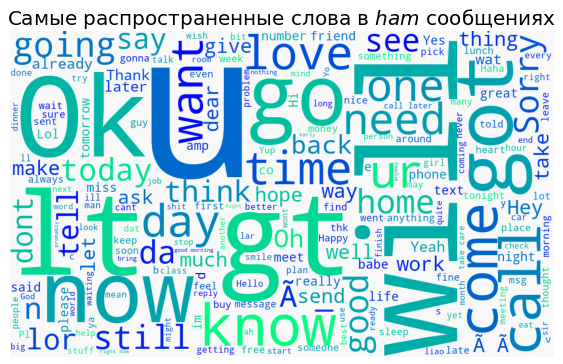

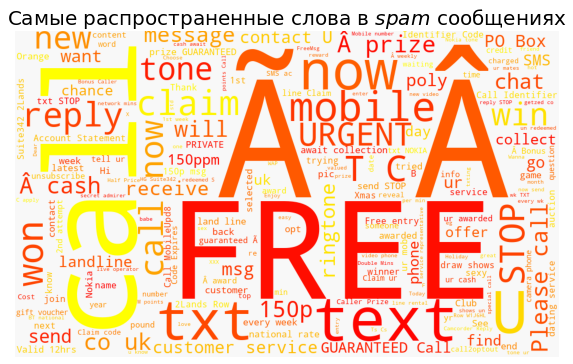

In [12]:
for v1, cmap in zip(["ham", "spam"], ["winter", "autumn"]):
    text = df.query("v1 == @v1")["message"].str.cat(sep=" ")
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Самые распространенные слова в ${v1}$ сообщениях", size=20)
    plt.show()

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['message'], df['is_spam'], stratify=df['is_spam'])

In [5]:
X_train.head(5)


1387    Hope ur head doesn't hurt 2 much ! Am ploughin...
5363    I think your mentor is , but not 100 percent s...
3023    I love ya too but try and budget your money be...
3696    You are a winner you have been specially selec...
5119          Lol for real. She told my dad I have cancer
Name: message, dtype: object

In [10]:
label2idx = {"spam": 1, "ham": 0}

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np

In [15]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs"))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

best_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=1)
best_classifier.fit(X_train, y_train)
best_predictions = best_classifier.predict(X_test)

baseline_accuracy = np.mean(best_predictions == y_test)
print("Baseline accuracy:", baseline_accuracy)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Иван\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Иван\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/mod

Baseline accuracy: 0.990667623833453


C:\Users\Иван\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Preparing Model

In [ ]:
!pip install transformers

In [6]:
from transformers import AutoTokenizer
from transformers import BertForSequenceClassification
import torch

In [7]:
BERT_MODEL = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

In [8]:
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element